In [1]:
# import relevant packages
import glob
import numpy as np
import nilearn
import nilearn.plotting
import nilearn.input_data
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# First we load all contrast files for 1st session

firstSes = glob.glob('/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/SPM_output/ses-1/1stLevel/_subject_id_*/con_0005.nii')
len(firstSes)

21

In [3]:
# load for 2nd session
secondSes = glob.glob('/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/SPM_output/ses-2/1stLevel/_subject_id_*/con_0005.nii')
len(secondSes)

21

['/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_BIDS/derivatives/fmriprep/sub-1253/ses-1/func/sub-1253_ses-1_task-Memory_space-MNI152NLin6Asym_desc-brain_mask.nii.gz', '/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_BIDS/derivatives/fmriprep/sub-1356/ses-1/func/sub-1356_ses-1_task-Memory_space-MNI152NLin6Asym_desc-brain_mask.nii.gz', '/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_BIDS/derivatives/fmriprep/sub-1339/ses-1/func/sub-1339_ses-1_task-Memory_space-MNI152NLin6Asym_desc-brain_mask.nii.gz', '/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_BIDS/derivatives/fmriprep/sub-1561/ses-1/func/sub-1561_ses-1_task-Memory_space-MNI152NLin6Asym_desc-brain_mask.nii.gz', '/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_BIDS/derivatives/fmriprep/sub-008/ses-1/func/sub-008_ses-1_task-Memory_space-MNI152NLin6Asym_desc-brain_mask.nii.gz', '/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_BIDS/derivatives/fmriprep/sub-1480/ses-1/

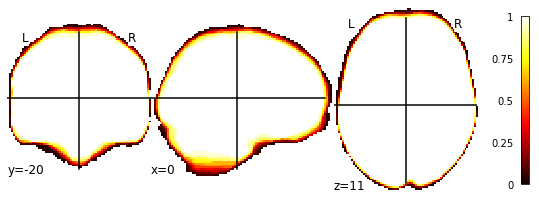

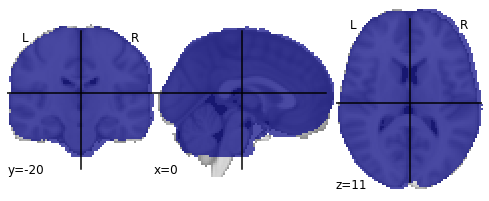

In [4]:
# build group brain mask

brainmasks = glob.glob('/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_BIDS/derivatives/fmriprep/sub-*/ses-1/func/sub-*_ses-1_task-Memory_space-MNI152NLin6Asym_desc-brain_mask.nii.gz')
print(brainmasks)
%matplotlib inline
#for mask in brainmasks:
 #   nilearn.plotting.plot_roi(mask)
    
mean_mask = nilearn.image.mean_img(brainmasks)
nilearn.plotting.plot_stat_map(mean_mask)
group_mask = nilearn.image.math_img("a>=0.95", a=mean_mask)
nilearn.plotting.plot_roi(group_mask)

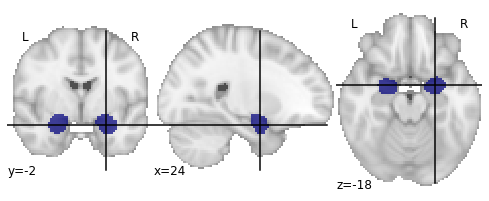

In [5]:
## Amygdala as mask
mask_file = '/media/Data/work/KPE_ROI/amygdala_association-test_z_FDR_0.01.nii.gz'
mask_file = nilearn.image.math_img("a>=20", a=mask_file)
%matplotlib inline
nilearn.plotting.plot_roi(mask_file)

In [159]:
# now we can use this mask to extract the contrast maps for each subject
fwhm = 4
masker = nilearn.input_data.NiftiMasker(mask_img=group_mask, 
                               sessions=None, smoothing_fwhm=fwhm, standardize=False, detrend=False, verbose=5)

In [6]:
masker = nilearn.input_data.NiftiMasker(mask_img=mask_file, 
                               sessions=None, smoothing_fwhm=6, standardize=False, detrend=False, verbose=5)

In [113]:
firstSession = []
for func in firstSes:
    print(f'Running {func}')
    beta = masker.fit_transform(func)
    firstSession.append(beta)

Running /media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/SPM_output/ses-1/1stLevel/_subject_id_1322/con_0005.nii
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,  
[NiftiMasker.transform_single_imgs] Resampling images


/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/nilearn/image/resampling.py:584: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  fill_value=fill_value)


[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Running /media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/SPM_output/ses-1/1stLevel/_subject_id_1387/con_0005.nii
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,  
[NiftiMasker.transform_single_imgs] Resampling images


/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/nilearn/image/resampling.py:584: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  fill_value=fill_value)


[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Running /media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/SPM_output/ses-1/1stLevel/_subject_id_1339/con_0005.nii
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,  
[NiftiMasker.transform_single_imgs] Resampling images


/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/nilearn/image/resampling.py:584: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  fill_value=fill_value)


[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Running /media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/SPM_output/ses-1/1stLevel/_subject_id_1464/con_0005.nii
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,  
[NiftiMasker.transform_single_imgs] Resampling images


/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/nilearn/image/resampling.py:584: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  fill_value=fill_value)


[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Running /media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/SPM_output/ses-1/1stLevel/_subject_id_1315/con_0005.nii
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Resampling images


/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/nilearn/image/resampling.py:584: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  fill_value=fill_value)


[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Running /media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/SPM_output/ses-1/1stLevel/_subject_id_1223/con_0005.nii
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Resampling images


/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/nilearn/image/resampling.py:584: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  fill_value=fill_value)


KeyboardInterrupt: 

In [ ]:
secondSession = []
for func in firstSes:
    print(f'Running {func}')
    beta = masker.fit_transform(func)
    secondSession.append(beta)

In [89]:
firstSarr = np.array(firstSession)
firstSarr_reshape= np.array(firstSarr).reshape(firstSarr.shape[0], firstSarr.shape[2])
firstSarr_reshape.shape


(21, 226968)

In [90]:
secondSarr = np.array(secondSession)
secondSarr_reshape= np.array(secondSarr).reshape(secondSarr.shape[0], secondSarr.shape[2])
secondSarr_reshape.shape


(21, 226968)

In [91]:
## Create condition labels (1 = plus, 0 = minus)
label1 = [1] * firstSarr.shape[0]
label2 = [0] * secondSarr.shape[0]
condition_label = np.concatenate([label1, label2])
condition_label

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [92]:
X = np.concatenate([np.array(firstSarr_reshape), np.array(secondSarr_reshape)])
Y = condition_label

In [481]:
## Create LOO cross-validation
nsubs = 21 # set number of subjects
# because we give it CS+ vector and CS- for each subject we will split the array to the two parts
# Then we will start looping, removing one subject (i.e. both CS+ vector and CS- vector) out, train on rest and prefict
# this subject's vectors 
X1 = X[:secondSarr_reshape.shape[0], :]
X2 = X[secondSarr_reshape.shape[0]:,:]
y1 = Y[:secondSarr_reshape.shape[0]]
y2 = Y[secondSarr_reshape.shape[0]:]
score = []
for i in range(nsubs):
    print(f'Running {i} fold') 
    X_test1 = X1[i,:]
    X_test2 = X2[i,:]
    y_test1 = y1[i]
    y_test2 = y2[i]
    
    X_train1 = np.delete(X1,i,axis=0)
    X_train2 = np.delete(X2,i,axis=0)
    y_train1 = np.delete(y1,i,axis=0)
    y_train2 = np.delete(y2,i,axis=0)

    y_test = [y_test1, y_test2]
    y_train = np.concatenate([y_train1, y_train2])
    X_train = np.concatenate([X_train1, X_train2])
    X_test = np.array([X_test1,X_test2])
    print(f'y test is {y_test}')
    print(f'Shape of X_train is {X_test.shape}')
    ## Running the prediction alg.
    model = XGBClassifier(n_jobs=8, 
                     verbose = 5)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    score.append(accuracy)

Running 0 fold


IndexError: index 0 is out of bounds for axis 0 with size 0

In [72]:
print("Accuracy: %0.2f (+/- %0.2f)" % (np.mean(score), np.std(score) * 2))

Accuracy: 0.50 (+/- 0.00)


In [313]:
#from sklearn.model_selection import StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
model = svm.SVC(kernel="rbf")
cv = XGBClassifier()#StratifiedKFold(n_splits=4) # running for each subject
mean_scores = []

svc = svm.SVC(kernel="rbf") #LinearSVC(random_state=None, verbose=5, C=1)
cv_scores = cross_val_score(svc,
                            X,
                            y=Y,
                            cv=cv,
                         #   groups=condition_label,
                            scoring="accuracy",
                            n_jobs=10, # set number of CPUs
                            verbose = 5 # set some details of the activity 
                            )
mean_scores.append(cv_scores.mean())

ValueError: Found input variables with inconsistent numbers of samples: [17, 42]

In [94]:
cv_scores

array([0.45454545, 0.45454545, 0.5       , 0.5       ])

In [7]:
# compare between groups
import pandas as pd
medication_cond = pd.read_csv('/home/or/kpe_task_analysis/task_based_analysis/kpe_sub_condition.csv')

ketamine_list = list(medication_cond['scr_id'][medication_cond['med_cond']==1])
ket_list = []
for subject in ketamine_list:
    print(subject)
    sub = subject.split('KPE')[1]
    ket_list.append(sub)


midazolam_list = list(medication_cond['scr_id'][medication_cond['med_cond']==0])
mid_list = []
for subject in midazolam_list:
    print(subject)
    sub = subject.split('KPE')[1]
    mid_list.append(sub)
#mid_list.remove('1480')

KPE008
KPE1223
KPE1293
KPE1307
KPE1315
KPE1322
KPE1339
KPE1343
KPE1387
KPE1464
KPE1499
KPE1253
KPE1263
KPE1351
KPE1356
KPE1364
KPE1369
KPE1390
KPE1403
KPE1468
KPE1480


In [8]:
ket_func = ['/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/work/fsl_analysis_ses2/modelfit/_subject_id_%s/modelestimate/mapflow/_modelestimate0/results/cope2.nii.gz'% (sub) for sub in ket_list]
mid_func = ['/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/work/fsl_analysis_ses2/modelfit/_subject_id_%s/modelestimate/mapflow/_modelestimate0/results/cope2.nii.gz' % (sub) for sub in mid_list]

In [279]:
mid_list.remove('1480')

In [9]:
ketamine = []
for func in ket_func:
    print(f'Running {func}')
    beta = masker.fit_transform(func)
    ketamine.append(beta)

Running /media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/work/fsl_analysis_ses2/modelfit/_subject_id_008/modelestimate/mapflow/_modelestimate0/results/cope2.nii.gz
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,  
[NiftiMasker.transform_single_imgs] Resampling images
[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Running /media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/work/fsl_analysis_ses2/modelfit/_subject_id_1223/modelestimate/mapflow/_modelestimate0/results/cope2.nii.gz
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mas

In [10]:
midazolam = []
for func in mid_func:
    print(f'Running {func}')
    beta = masker.fit_transform(func)
    midazolam.append(beta)

Running /media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/work/fsl_analysis_ses2/modelfit/_subject_id_1253/modelestimate/mapflow/_modelestimate0/results/cope2.nii.gz
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,  
[NiftiMasker.transform_single_imgs] Resampling images
[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Running /media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/work/fsl_analysis_ses2/modelfit/_subject_id_1263/modelestimate/mapflow/_modelestimate0/results/cope2.nii.gz
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling ma

In [11]:
ketArr = np.array(ketamine)
ketArr_reshape= np.array(ketArr).reshape(ketArr.shape[0], ketArr.shape[2])
ketArr_reshape.shape


(11, 932)

In [12]:
midArr = np.array(midazolam)
midArr_reshape= np.array(midArr).reshape(midArr.shape[0], midArr.shape[2])
midArr_reshape.shape


(10, 932)

In [13]:
## Create condition labels (1 = plus, 0 = minus)
label1 = [1] * ketArr.shape[0]
label2 = [0] * midArr.shape[0]
condition_label = np.concatenate([label1, label2])
condition_label

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [14]:
X = np.concatenate([ketArr, midArr])
X = X.reshape(X.shape[0], midArr_reshape.shape[1])
X.shape

(21, 932)

In [24]:
#from sklearn.model_selection import StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import StratifiedKFold
from sklearn import svm
model = XGBClassifier(n_jobs=8, 
                     verbose = 9, random_state=None)

## Here we use stratified K-fold with shuffling to generate different shuffling of leave one subject out
cv = StratifiedKFold(n_splits=10, shuffle=True) # running for each subject
mean_scores = []

#svc = svm.SVC(kernel="rbf") #LinearSVC(random_state=None, verbose=5, C=1)
cv_scores = cross_val_score(model,
                            X,
                            y=condition_label,
                            cv=cv,
                            groups=condition_label,
                            scoring= "f1", #"roc_auc",
                            n_jobs=10, # set number of CPUs
                            verbose = 5 # set some details of the activity 
                            )
mean_scores.append(cv_scores.mean())

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.5s remaining:    1.1s
[Parallel(n_jobs=10)]: Done   6 out of  10 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.6s finished


In [40]:
from sklearn.model_selection import cross_validate
mean_scores = []

#svc = svm.SVC(kernel="rbf") #LinearSVC(random_state=None, verbose=5, C=1)
cv_scores = cross_validate(model,
                            X,
                            y=condition_label,
                            cv=cv,
                            groups=condition_label,
                            scoring= {"f1","recall","roc_auc"},
                            n_jobs=10, # set number of CPUs
                            verbose = 5 # set some details of the activity 
                            )
mean_scores.append(cv_scores)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.6s remaining:    1.3s
[Parallel(n_jobs=10)]: Done   6 out of  10 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.8s finished


In [41]:
mean_scores

[{'fit_time': array([0.49730396, 0.47715163, 0.59267092, 0.59635162, 0.5682416 ,
         0.55760264, 0.46823478, 0.41504502, 0.48609924, 0.54467177]),
  'score_time': array([0.01749682, 0.01060271, 0.01700974, 0.01899648, 0.01698208,
         0.01287961, 0.01524997, 0.01615047, 0.01709342, 0.03051949]),
  'test_f1': array([1.        , 0.66666667, 0.66666667, 1.        , 1.        ,
         1.        , 1.        , 0.66666667, 1.        , 0.        ]),
  'test_roc_auc': array([1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 0.5]),
  'test_recall': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 0.])}]

In [25]:
print(mean_scores)
cv_scores
#print("Accuracy: %0.2f (+/- %0.2f)" % (, np.std(rand_score) * 2))

[0.8]


array([0.66666667, 0.        , 1.        , 1.        , 1.        ,
       0.66666667, 1.        , 0.66666667, 1.        , 1.        ])

## Use shuffle split to randomize and run the XGboost N times
This will create a distribution of estimation level


In [26]:
n_iter = 1000
rand_score = []
for i in range(n_iter):
    print(f' Running {i+1} iteration')
    mean_scores = []
    scores = cross_val_score(model,
                            X,
                            y=condition_label,
                            cv=cv,
                            groups=condition_label,
                            scoring= "accuracy",
                            n_jobs=10, # set number of CPUs
                            #verbose = 5 # set some details of the activity 
                            )
    mean_scores.append(scores.mean())
    rand_score.append(mean_scores)

 Running 1 iteration
 Running 2 iteration
 Running 3 iteration
 Running 4 iteration
 Running 5 iteration
 Running 6 iteration
 Running 7 iteration
 Running 8 iteration
 Running 9 iteration
 Running 10 iteration
 Running 11 iteration
 Running 12 iteration
 Running 13 iteration
 Running 14 iteration
 Running 15 iteration
 Running 16 iteration
 Running 17 iteration
 Running 18 iteration
 Running 19 iteration
 Running 20 iteration
 Running 21 iteration
 Running 22 iteration
 Running 23 iteration
 Running 24 iteration
 Running 25 iteration
 Running 26 iteration
 Running 27 iteration
 Running 28 iteration
 Running 29 iteration
 Running 30 iteration
 Running 31 iteration
 Running 32 iteration
 Running 33 iteration
 Running 34 iteration
 Running 35 iteration
 Running 36 iteration
 Running 37 iteration
 Running 38 iteration
 Running 39 iteration
 Running 40 iteration
 Running 41 iteration
 Running 42 iteration
 Running 43 iteration
 Running 44 iteration
 Running 45 iteration
 Running 46 iterati

 Running 362 iteration
 Running 363 iteration
 Running 364 iteration
 Running 365 iteration
 Running 366 iteration
 Running 367 iteration
 Running 368 iteration
 Running 369 iteration
 Running 370 iteration
 Running 371 iteration
 Running 372 iteration
 Running 373 iteration
 Running 374 iteration
 Running 375 iteration
 Running 376 iteration
 Running 377 iteration
 Running 378 iteration
 Running 379 iteration
 Running 380 iteration
 Running 381 iteration
 Running 382 iteration
 Running 383 iteration
 Running 384 iteration
 Running 385 iteration
 Running 386 iteration
 Running 387 iteration
 Running 388 iteration
 Running 389 iteration
 Running 390 iteration
 Running 391 iteration
 Running 392 iteration
 Running 393 iteration
 Running 394 iteration
 Running 395 iteration
 Running 396 iteration
 Running 397 iteration
 Running 398 iteration
 Running 399 iteration
 Running 400 iteration
 Running 401 iteration
 Running 402 iteration
 Running 403 iteration
 Running 404 iteration
 Running 40

 Running 719 iteration
 Running 720 iteration
 Running 721 iteration
 Running 722 iteration
 Running 723 iteration
 Running 724 iteration
 Running 725 iteration
 Running 726 iteration
 Running 727 iteration
 Running 728 iteration
 Running 729 iteration
 Running 730 iteration
 Running 731 iteration
 Running 732 iteration
 Running 733 iteration
 Running 734 iteration
 Running 735 iteration
 Running 736 iteration
 Running 737 iteration
 Running 738 iteration
 Running 739 iteration
 Running 740 iteration
 Running 741 iteration
 Running 742 iteration
 Running 743 iteration
 Running 744 iteration
 Running 745 iteration
 Running 746 iteration
 Running 747 iteration
 Running 748 iteration
 Running 749 iteration
 Running 750 iteration
 Running 751 iteration
 Running 752 iteration
 Running 753 iteration
 Running 754 iteration
 Running 755 iteration
 Running 756 iteration
 Running 757 iteration
 Running 758 iteration
 Running 759 iteration
 Running 760 iteration
 Running 761 iteration
 Running 76

Accuracy: 0.70 (+/- 0.14)


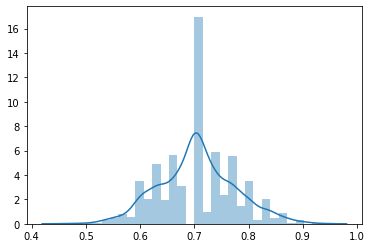

In [27]:
rand_score = np.array(rand_score)
print("Accuracy: %0.2f (+/- %0.2f)" % (np.mean(rand_score), np.std(rand_score) * 2))
sns.distplot(rand_score)

## Now we will do similar thing - just shuffling the condition label (Y) so we basically randomizing the lables
This should generate a chance level prediction

In [35]:
## Lets do permutation tests - shuffling the condition label
import random
condPerm = np.array(condition_label)
permScor = []
#cv = KFold(n_splits=10)
for i in range(n_iter):
    print (f'Running the {i+1} iteration')
    random.shuffle(condPerm)
    print(condPerm)
    
    mean_scores = []
    cv_scores = cross_val_score(model,
                            X,
                            y=condPerm,
                            cv=cv,
                            groups=condPerm,
                            scoring="f1",#"roc_auc",
                            n_jobs=11, # set number of CPUs
                            #verbose = 5 # set some details of the activity 
                            )
    mean_scores.append(cv_scores.mean())
    permScor.append(mean_scores)

Running the 1 iteration
[0 0 1 1 1 1 0 1 1 0 0 0 0 0 1 1 1 1 0 1 0]


ValueError: For evaluating multiple scores, use sklearn.model_selection.cross_validate instead. {'f1', 'roc_auc'} was passed.

 Mean of permutation score is 0.45543


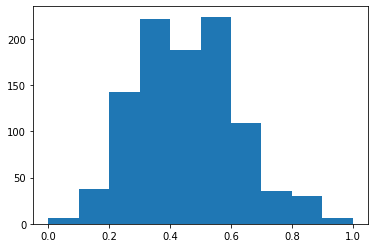

In [29]:
# now lets see the mean score
score = np.array(permScor)

#import matplotlib.pyplot as plt
plt.hist(score)
print(f' Mean of permutation score is {np.mean(score)}')

 Chances of mean permutation score to be random is 0.071


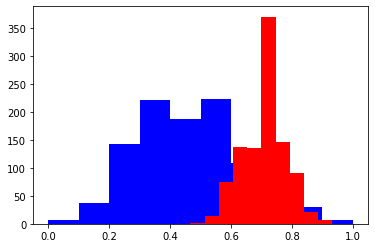

In [30]:
#plot permutation histogram and real one
plt.hist(score, color="blue")
plt.hist(rand_score, color="red")
# chances of getting our score
print(f' Chances of mean permutation score to be random is {len(score[score>=np.mean(rand_score)])/len(score)}')

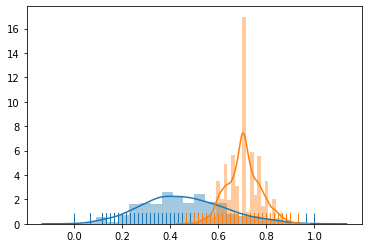

In [31]:

sns.distplot(score, hist=True, rug=True)
sns.distplot(rand_score, hist=True, rug=True)

(array([0.002, 0.014, 0.075, 0.137, 0.136, 0.371, 0.146, 0.091, 0.022,
        0.006]),
 array([0.46666667, 0.51333333, 0.56      , 0.60666667, 0.65333333,
        0.7       , 0.74666667, 0.79333333, 0.84      , 0.88666667,
        0.93333333]),
 <a list of 10 Patch objects>)

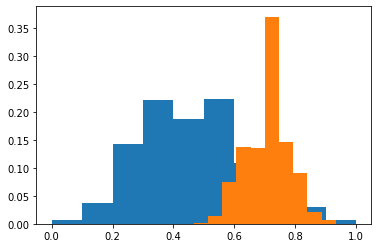

In [32]:
weights = np.ones_like(score) / len(score)
weights_real = np.ones_like(rand_score) / len(rand_score)
plt.hist(score, weights=weights)
plt.hist(rand_score, weights=weights_real)

In [780]:
import xgboost as xgb
params = {'objective':'binary:logistic', 'n_estimators':2}
data_dmatrix = xgb.DMatrix(data=X,label=condition_label)
cv_results = xgb.cv(dtrain=data_dmatrix,params=params,  nfold=10, shuffle=False, stratified = True,
                    num_boost_round=50,early_stopping_rounds=10, metrics="auc", as_pandas=True)#, seed=123)

In [781]:
cv_results


,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.959444,0.020344,0.625,0.301040
1,0.989444,0.019791,0.750,0.335410
2,0.999444,0.001667,0.850,0.320156


In [782]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

[16:40:20] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1588600955503/work/src/learner.cc:328: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




ImportError: You must install graphviz to plot tree

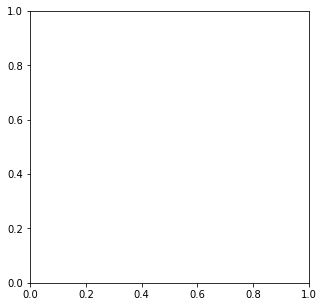

In [783]:

xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

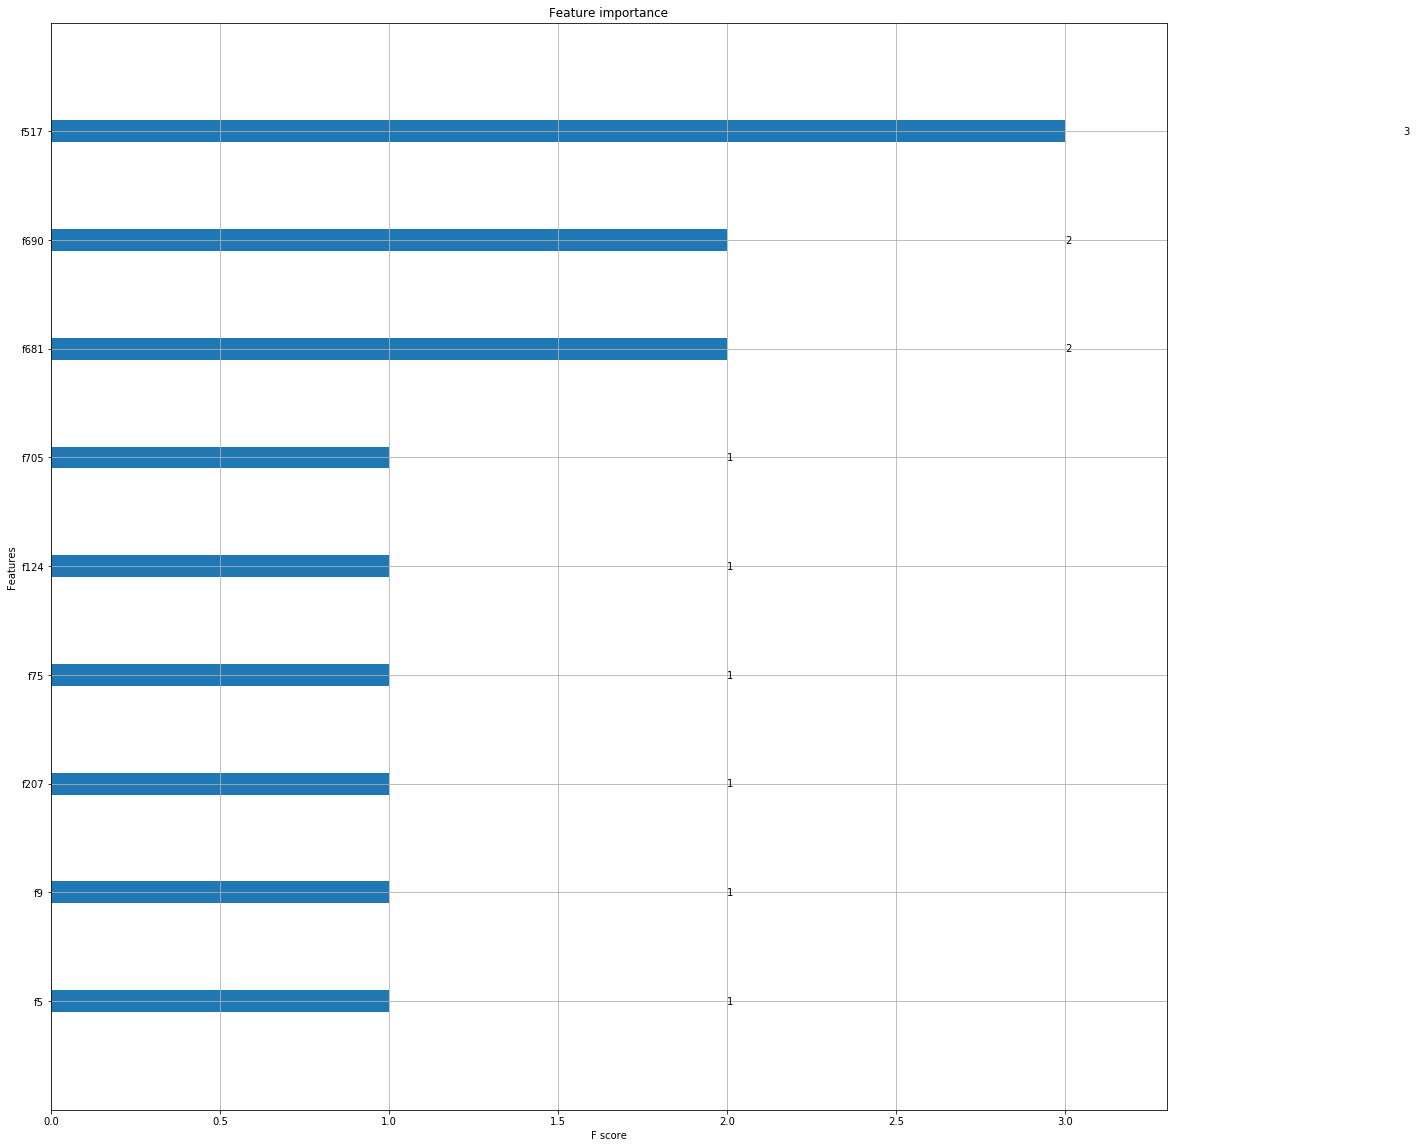

In [788]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [15, 15]
plt.show()

In [792]:
xg_reg.

TypeError: attr() missing 1 required positional argument: 'key'